# We will estimate the position of an object in a scene using SIFT

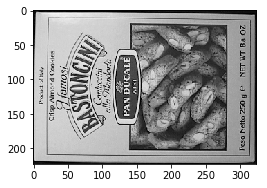

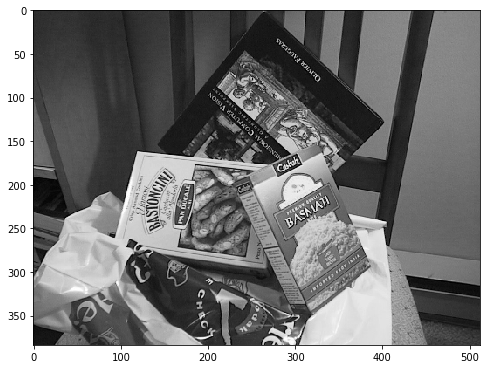

In [10]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt

img_box = cv2.imread('box.pgm',0)   
img_scene = cv2.imread('scene.pgm',0) 
plt.figure(figsize=[4,4])
plt.imshow(img_box, 'gray')
plt.figure(figsize=[8,8])
plt.imshow(img_scene, 'gray')

## 1. Feature detection and description 

In [11]:
# SIFT features calculation on both images
sift = cv2.xfeatures2d.SIFT_create(nfeatures=0, nOctaveLayers=3, contrastThreshold=0.04, 
                                   edgeThreshold=10, sigma=1.6)

kp_box, des_box = sift.detectAndCompute(img_box,None)
kp_scene, des_scene = sift.detectAndCompute(img_scene,None)

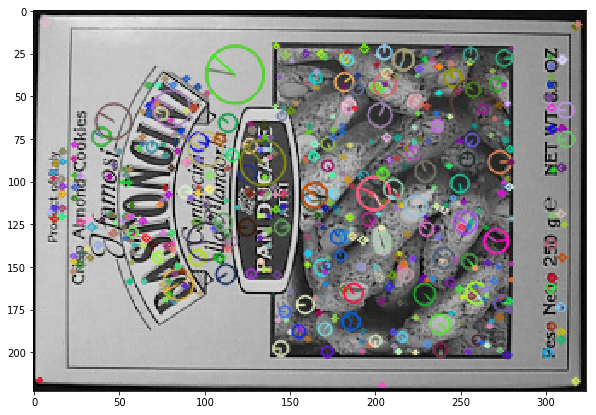

In [12]:
# Draw keypoints on box image
image_kp_box = np.zeros([img_box.shape[0], img_box.shape[1], 3], dtype=np.uint8)
cv2.drawKeypoints(img_box, kp_box, image_kp_box, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=[15, 7])
plt.imshow(image_kp_box)

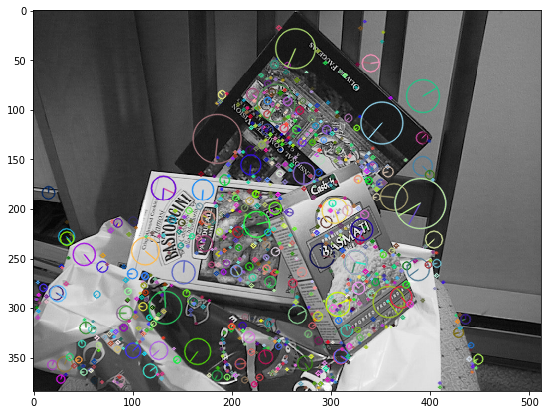

In [13]:
# Draw keypoints on scene
image_kp_scene = np.zeros([img_scene.shape[0], img_scene.shape[1], 3], dtype=np.uint8)
cv2.drawKeypoints(img_scene, kp_scene, image_kp_scene, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=[15, 7])
plt.imshow(image_kp_scene)

## 2. Feature matching

We will use the method BFMatcher from OpenCV (brute force matcher) to find the closest keypoints in the two images.

In [14]:
# Create matcher object
# crossCheck=True returns only matching points p1 and p2 where p2 is the 
# closest point to p1 and p1 is also the closest to p2
matcher = cv2.BFMatcher(crossCheck=False)

# Do the match
# k=2 return the best two matches for each descriptor
matches = matcher.knnMatch(des_box, des_scene, k=2)

# List of two closest matchs for keypoint 0 in des_box
matches_kp0 = matches[0]
# Closest match for keypoint 0 in des_box
matching_kp = matches_kp0[0]
print("Keypoint index: {}, matching keypoint index: {}, distance: {}".format(
        matching_kp.queryIdx, matching_kp.trainIdx, matching_kp.distance))

# Second closest match for keypoint 0 in des_box
matching_kp = matches_kp0[1]
print("Keypoint index: {}, matching keypoint index: {}, distance: {}".format(
        matching_kp.queryIdx, matching_kp.trainIdx, matching_kp.distance))

Keypoint index: 0, matching keypoint index: 336, distance: 212.0023651123047
Keypoint index: 0, matching keypoint index: 717, distance: 256.8598937988281


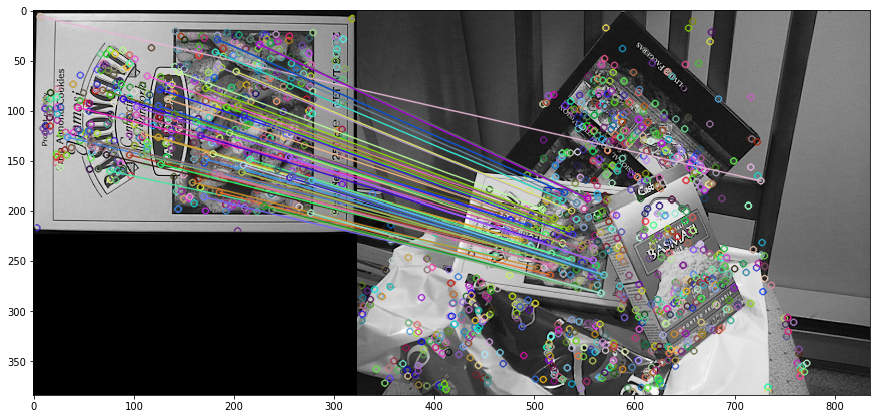

In [15]:
# Find good matches using Lowe's ratio test
good_matches = []
for m1, m2 in matches:
    closest_kp_distance = m1.distance
    second_closest_kp_distance = m2.distance
    if closest_kp_distance/second_closest_kp_distance < 0.7:
        good_matches.append(m1)

img_matches = cv2.drawMatches(img_box, kp_box, img_scene,kp_scene, good_matches, None)

plt.figure(figsize=[15,8])
plt.imshow(img_matches, 'gray')

## 3. Identify the transformation 

In [16]:
# Get positions of matching keypoints
box_kp_pos = np.zeros([len(good_matches), 2], dtype=np.float32)
scene_kp_pos = np.zeros([len(good_matches), 2], dtype=np.float32)
for i, m in enumerate(good_matches):
    box_kp_pos[i] = kp_box[m.queryIdx].pt
    scene_kp_pos[i] = kp_scene[m.trainIdx].pt
    
# T is the transformation matrix, mask is a boolean array indicating inlier points
T, mask = cv2.findHomography(box_kp_pos, scene_kp_pos, 
                             cv2.RANSAC, ransacReprojThreshold=3.0) 
matchesMask = mask.ravel().tolist()

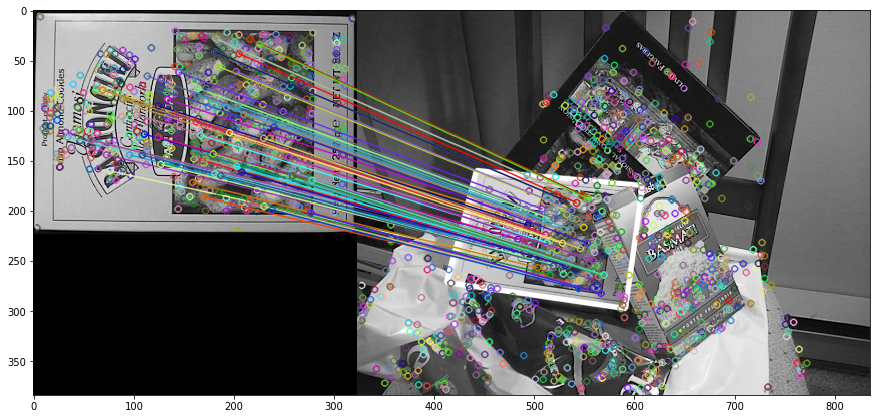

In [17]:
# Find transformation of rectangle delimiting object
h, w = img_box.shape
box_bounds = np.float32([[0,0], [0,h-1], [w-1,h-1], [w-1,0] ]).reshape(-1,1,2)
box_bounds_in_scene = cv2.perspectiveTransform(box_bounds, T)

# Draw polygon in the scene
img_scene_box = cv2.polylines(img_scene.copy(), [np.int32(box_bounds_in_scene)], True, 255, 3, cv2.LINE_AA)

img_matches_RANSAC = cv2.drawMatches(img_box, kp_box, img_scene_box, kp_scene, good_matches, None, matchesMask=matchesMask)
plt.figure(figsize=[15,8])
plt.imshow(img_matches_RANSAC, 'gray')